# Otto Group Product Classification Challenge

## 背景介绍
奥托集团是世界上最大的电子商务公司之一，在20多个国家设有子公司。该公司每天都在世界各地销售数百万种产品,所以对其产品根据性能合理的分类非常重要。

不过,在实际工作中,工作人员发现,产品存在大量的五分类。本案例要求,你对奥拓集团的产品进行正确的分分类。尽可能的提供分类的准确性。

链接：https://www.kaggle.com/c/otto-group-product-classification-challenge/overview


## 数据集介绍

- 本案例中，数据集包含大约200,000种产品的93个特征。
- 其目的是建立一个能够区分otto公司主要产品类别的预测模型。
- 所有产品共被分成九个类别（例如时装，电子产品等）。

## 评分标准

![avatar](../source/103.jpg) 

- i表示样本，j表示类别。$p_{ij}$代表第i个样本属于类别j的概率
- 如果第i个样本真的属于类别j，则$y_{ij}$等于1，否则为0。
- 根据上公式，假如你将所有的测试样本都正确分类，所有$p_{ij}$都是1，那每个log($p_{ij}$)都是0，最终的logloss也是0。
- 假如第1个样本本来是属于1类别的，但是你给它的类别概率$p_{ij}$=0.1，那logloss就会累加上log(0.1)这一项。我们知道这一项是负数，而且$p_{ij}$越小，负得越多，如果$p_{ij}$=0，将是无穷。这会导致这种情况：你分错了一个，logloss就是无穷。这当然不合理，为了避免这一情况，我们对非常小的值做如下处理：$max(min(p, 1-10^{-15}),10^{-15})$
- 也就是说最小不会小于$10^{-15}$

- 实际上,上述损失函数如果是对于二分类问题,就可以简化为:
![avatar](../source/104.jpg) 

## 流程分析

- 获取数据
- 数据基本处理
    - 数据量比较大，尝试是否可以进行数据分割
    - 转换目标值表示方式
- 模型训练
- 模型基本训练


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv("../data/otto/train.csv")
data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [5]:
data.shape

(61878, 95)

In [6]:
data.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61878.000000,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


In [9]:
def show_category_bar(category):    
    sns.countplot(category)
    plt.show()

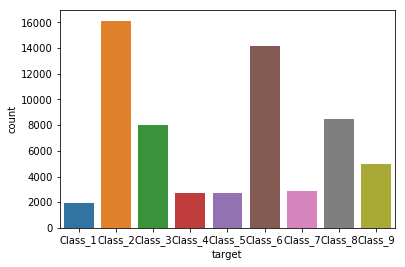

In [10]:
show_category_bar(data.target)

由上图可以看出,该数据类别不均衡,所以需要后期处理

## 数据基本处理
数据已经经过脱敏,不再需要特殊处理

### 截取部分数据

In [12]:
new1_data = data[:10000]
new1_data.shape

(10000, 95)

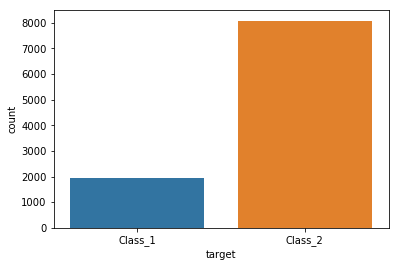

In [13]:
show_category_bar(new1_data.target)

显然,我们直接截取的数据只有 2 个类别,所以这种截取方式不可取

### 随机欠采样

In [15]:
y = data['target']
x = data.drop(['id', 'target'], axis = 1)
x.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,6,1,5,0,0,1,...,22,0,1,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [17]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = rus.fit_resample(x, y)


In [18]:
x.shape, y.shape

((61878, 93), (61878,))

In [19]:
x_resampled.shape, y_resampled.shape

((17361, 93), (17361,))

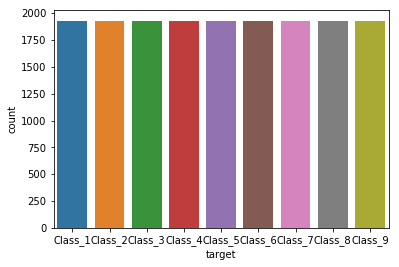

In [20]:
show_category_bar(y_resampled)

### 把标签值转换为数字

In [21]:
y_resampled.head()

0    Class_1
1    Class_1
2    Class_1
3    Class_1
4    Class_1
Name: target, dtype: object

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)
y_resampled[:5]

array([0, 0, 0, 0, 0])

### 分割数据

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2)
x_train.shape, y_train.shape

((13888, 93), (13888,))

((3473, 93), (3473,))

## 模型训练
### 基本模型训练

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True)
rf.fit(x_train, y_train)

RandomForestClassifier(oob_score=True)

In [26]:
y_pre = rf.predict(x_test)

In [27]:
rf.score(x_test, y_test)

0.7624532104808522

In [28]:
rf.oob_score_

0.7675691244239631

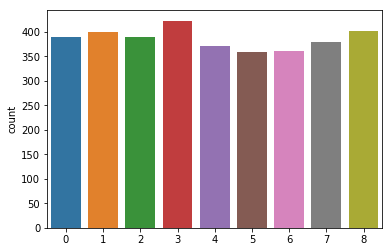

In [29]:
show_category_bar(y_pre)

In [30]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pre, eps=1e-15, normalize=True)

ValueError: y_true and y_pred contain different number of classes 9, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4 5 6 7 8]

上面报错原因:logloss使用过程中,必须要求将输出用one-hot表示,

需要将这个多类别问题的输出结果通过OneHotEncoder修改为如下:

In [35]:
y_test.reshape(-1, 1)[:5]

array([[0],
       [1],
       [4],
       [4],
       [2]])

In [34]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse=False)
y_test1 = one_hot.fit_transform(y_test.reshape(-1, 1))
y_pre1 = one_hot.fit_transform(y_pre.reshape(-1, 1))

In [36]:
y_pre1[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
log_loss(y_test1, y_pre1, eps=1e-15, normalize=True)

8.204575446530765

In [38]:
y_pre_proba = rf.predict_proba(x_test)
y_pre_proba[:5]

array([[0.33, 0.02, 0.03, 0.14, 0.01, 0.13, 0.19, 0.1 , 0.05],
       [0.03, 0.4 , 0.21, 0.31, 0.  , 0.  , 0.02, 0.01, 0.02],
       [0.05, 0.03, 0.01, 0.07, 0.71, 0.  , 0.05, 0.04, 0.04],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.03, 0.4 , 0.31, 0.1 , 0.01, 0.  , 0.13, 0.  , 0.02]])

In [42]:
log_loss(y_test1, y_pre_proba, eps=1e-15, normalize=True)

0.7389751105691842

## 模型调优
n_estimators, max_feature, max_depth, min_samples_leaf

确定最优的n_estimators

In [46]:
def show_para_tune(x, y1, y2, x_label, y1_label, y2_label):
    fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(20,8), dpi=100)
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)
    
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y1_label)
    
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y2_label)
    
    axes[0].grid(True)
    axes[1].grid(True)
    plt.show()


In [44]:
tuned_parameters = range(10, 200, 10)

accuracy_t = np.zeros(len(tuned_parameters))
error_t = np.zeros(len(tuned_parameters))

for j, para in enumerate(tuned_parameters):
    rf2 = RandomForestClassifier(n_estimators=para, 
                                 max_depth=10, 
                                 max_features=10, 
                                 min_samples_leaf=10, 
                                 oob_score=True, 
                                 random_state=0,
                                 n_jobs=-1)
    rf2.fit(x_train, y_train)
    accuracy_t[j]=rf2.oob_score_
    y_pre = rf2.predict_proba(x_test)
    error_t[j] = log_loss(y_test, y_pre, eps=1e-15, normalize=True)
    print(error_t)
    
    
    
    
    
    
    

[1.13569839 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[1.13569839 1.12595813 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[1.13569839 1.12595813 1.1323552  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[1.13569839 1.12595813 1.1323552  1.12786345 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[1.13569839 1.12595813 1.1323552  1.12786345 1.1229517  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[1.13569839 1.12595813 1.1323552  1.12786345 1.122

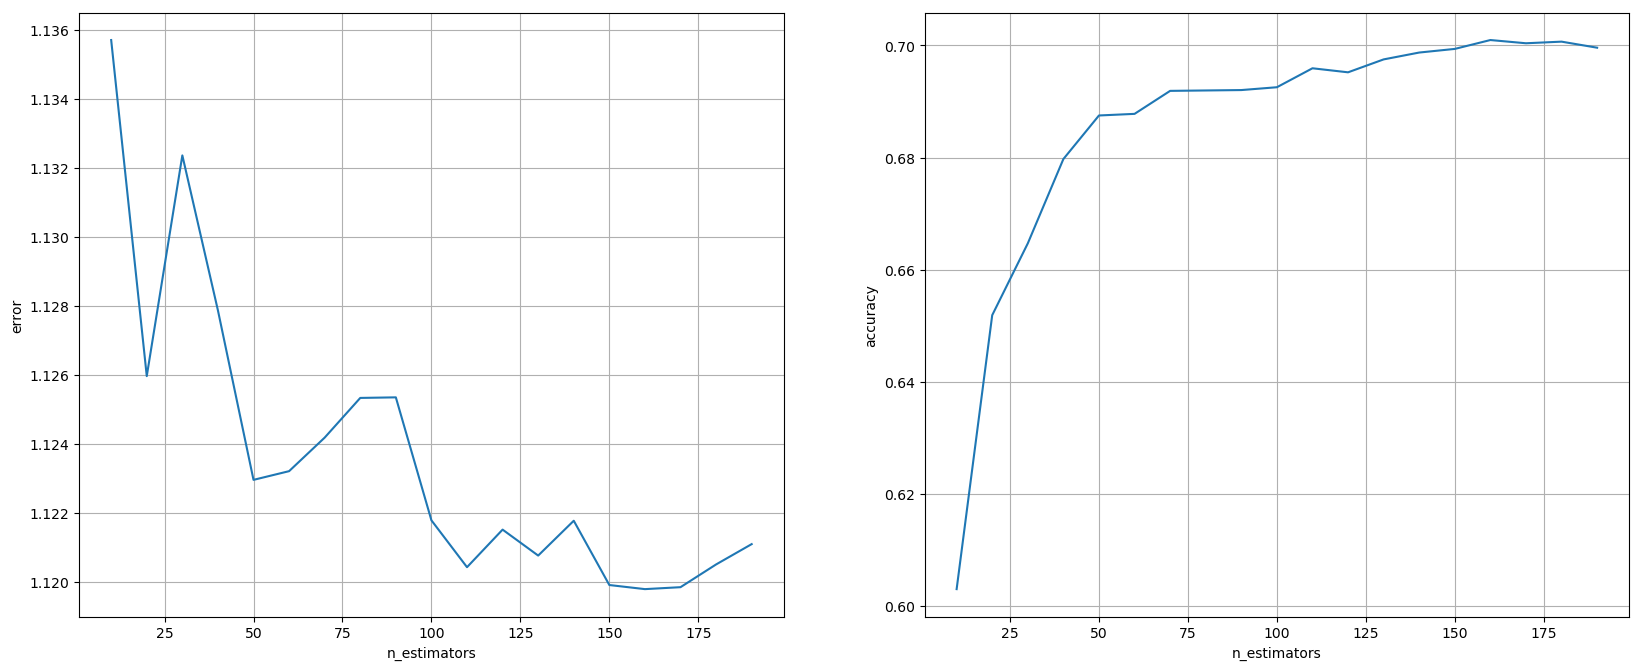

In [47]:
show_para_tune(tuned_parameters, error_t, accuracy_t, 'n_estimators', 'error', 'accuracy')

经过图像展示,最后确定n_estimators=175的时候,表现效果不错

## 确定最优的max_features¶

In [48]:
tuned_parameters = range(5, 40, 5)

accuracy_t = np.zeros(len(tuned_parameters))
error_t = np.zeros(len(tuned_parameters))

for j, para in enumerate(tuned_parameters):
    rf2 = RandomForestClassifier(n_estimators=175, 
                                 max_depth=10, 
                                 max_features=para, 
                                 min_samples_leaf=10, 
                                 oob_score=True, 
                                 random_state=0,
                                 n_jobs=-1)
    rf2.fit(x_train, y_train)
    accuracy_t[j]=rf2.oob_score_
    y_pre = rf2.predict_proba(x_test)
    error_t[j] = log_loss(y_test, y_pre, eps=1e-15, normalize=True)
    print(error_t)

[1.21663784 0.         0.         0.         0.         0.
 0.        ]
[1.21663784 1.12041988 0.         0.         0.         0.
 0.        ]
[1.21663784 1.12041988 1.09376579 0.         0.         0.
 0.        ]
[1.21663784 1.12041988 1.09376579 1.0748467  0.         0.
 0.        ]
[1.21663784 1.12041988 1.09376579 1.0748467  1.07367898 0.
 0.        ]
[1.21663784 1.12041988 1.09376579 1.0748467  1.07367898 1.07010199
 0.        ]
[1.21663784 1.12041988 1.09376579 1.0748467  1.07367898 1.07010199
 1.07231484]


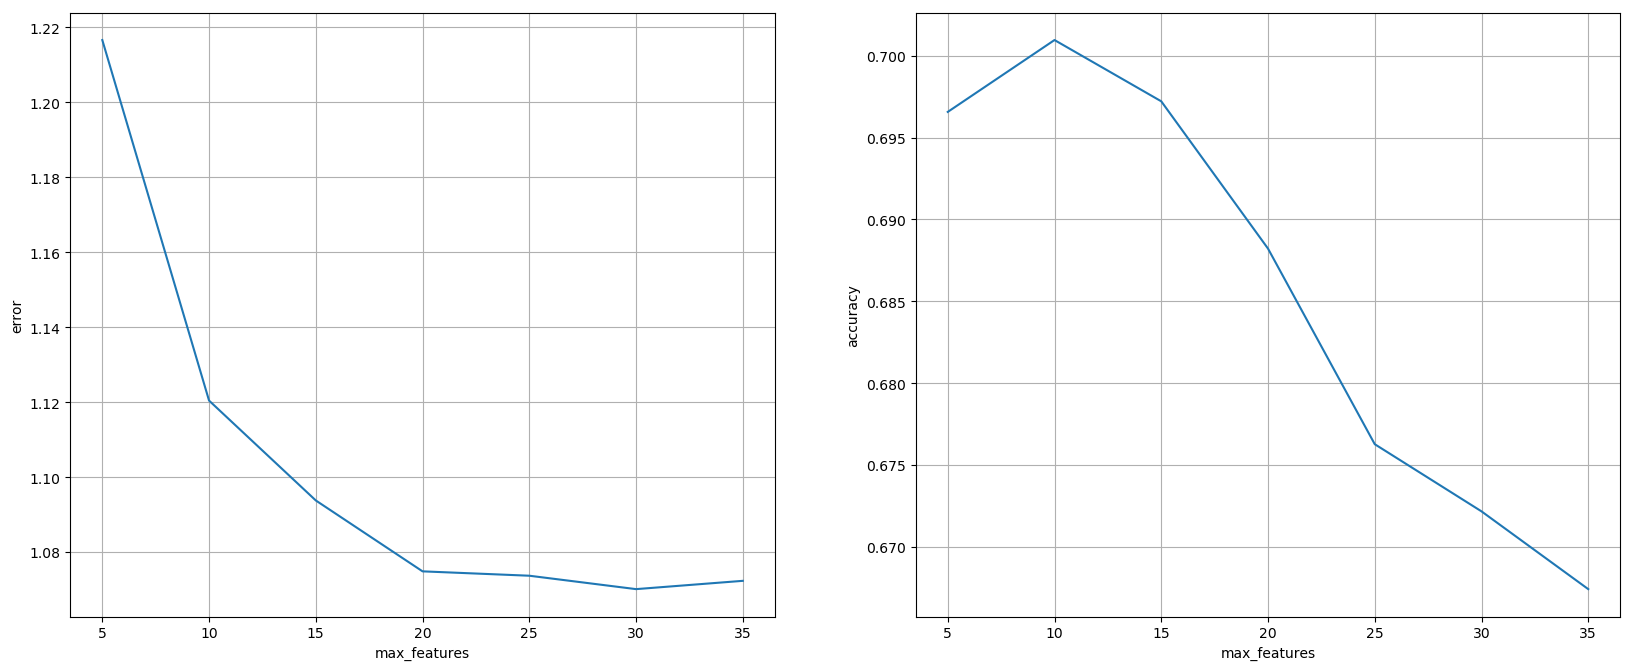

In [49]:
show_para_tune(tuned_parameters, error_t, accuracy_t, 'max_features', 'error', 'accuracy')

经过图像展示,最后确定max_features=15的时候,表现效果不错

## 确定最优的max_depth¶

In [50]:
tuned_parameters = range(10, 100, 10)

accuracy_t = np.zeros(len(tuned_parameters))
error_t = np.zeros(len(tuned_parameters))

for j, para in enumerate(tuned_parameters):
    rf2 = RandomForestClassifier(n_estimators=175, 
                                 max_depth=para, 
                                 max_features=15, 
                                 min_samples_leaf=10, 
                                 oob_score=True, 
                                 random_state=0,
                                 n_jobs=-1)
    rf2.fit(x_train, y_train)
    accuracy_t[j]=rf2.oob_score_
    y_pre = rf2.predict_proba(x_test)
    error_t[j] = log_loss(y_test, y_pre, eps=1e-15, normalize=True)
    print(error_t)

[1.09376579 0.         0.         0.         0.         0.
 0.         0.         0.        ]
[1.09376579 0.86095811 0.         0.         0.         0.
 0.         0.         0.        ]
[1.09376579 0.86095811 0.837095   0.         0.         0.
 0.         0.         0.        ]
[1.09376579 0.86095811 0.837095   0.83669545 0.         0.
 0.         0.         0.        ]
[1.09376579 0.86095811 0.837095   0.83669545 0.83671208 0.
 0.         0.         0.        ]
[1.09376579 0.86095811 0.837095   0.83669545 0.83671208 0.83671208
 0.         0.         0.        ]
[1.09376579 0.86095811 0.837095   0.83669545 0.83671208 0.83671208
 0.83671208 0.         0.        ]
[1.09376579 0.86095811 0.837095   0.83669545 0.83671208 0.83671208
 0.83671208 0.83671208 0.        ]
[1.09376579 0.86095811 0.837095   0.83669545 0.83671208 0.83671208
 0.83671208 0.83671208 0.83671208]


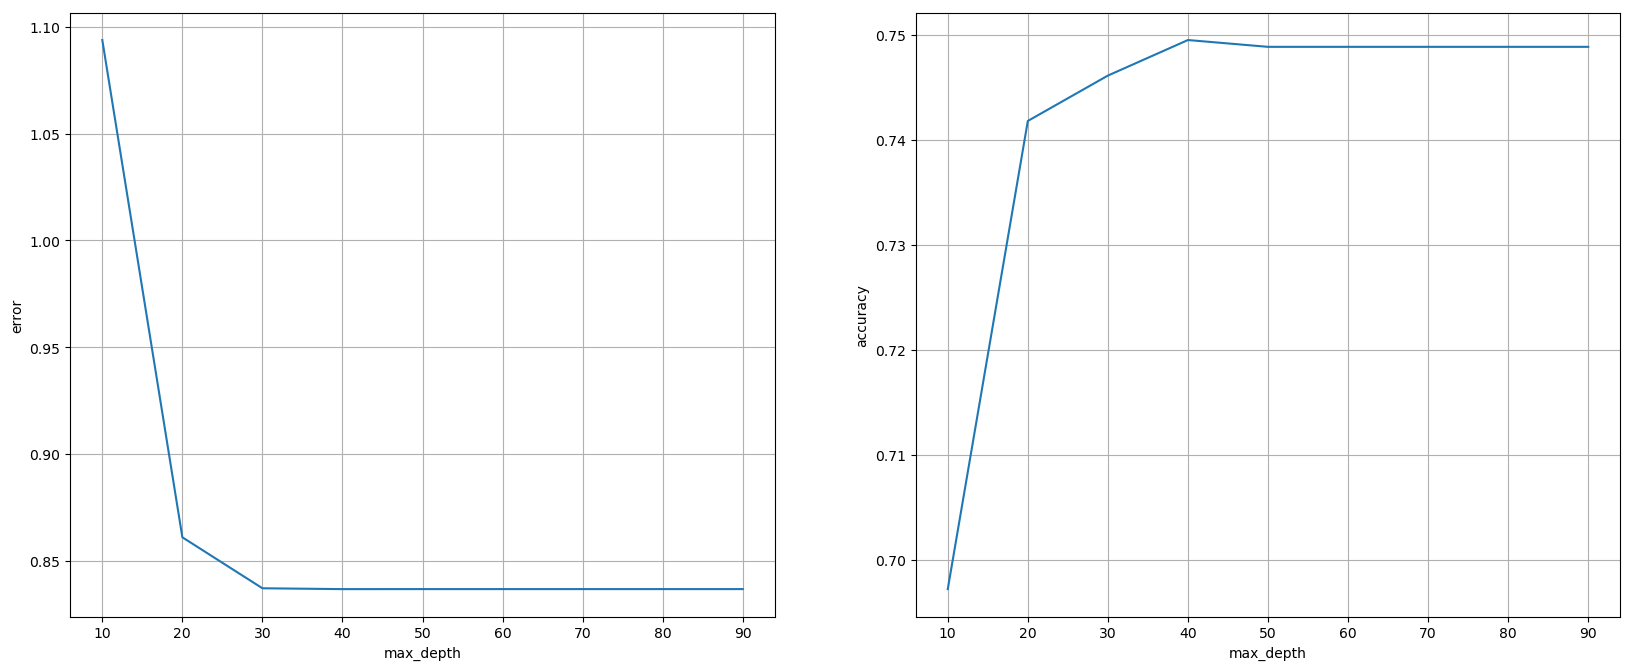

In [51]:
show_para_tune(tuned_parameters, error_t, accuracy_t, 'max_depth', 'error', 'accuracy')

经过图像展示,最后确定max_depth=30的时候,表现效果不错

## 确定最优的min_sample_leaf

In [52]:
tuned_parameters = range(1, 10, 1)

accuracy_t = np.zeros(len(tuned_parameters))
error_t = np.zeros(len(tuned_parameters))

for j, para in enumerate(tuned_parameters):
    rf2 = RandomForestClassifier(n_estimators=175, 
                                 max_depth=30, 
                                 max_features=15, 
                                 min_samples_leaf=para, 
                                 oob_score=True, 
                                 random_state=0,
                                 n_jobs=-1)
    rf2.fit(x_train, y_train)
    accuracy_t[j]=rf2.oob_score_
    y_pre = rf2.predict_proba(x_test)
    error_t[j] = log_loss(y_test, y_pre, eps=1e-15, normalize=True)
    print(error_t)


[0.7207305 0.        0.        0.        0.        0.        0.
 0.        0.       ]
[0.7207305  0.73483772 0.         0.         0.         0.
 0.         0.         0.        ]
[0.7207305  0.73483772 0.7549284  0.         0.         0.
 0.         0.         0.        ]
[0.7207305  0.73483772 0.7549284  0.76979011 0.         0.
 0.         0.         0.        ]
[0.7207305  0.73483772 0.7549284  0.76979011 0.7833266  0.
 0.         0.         0.        ]
[0.7207305  0.73483772 0.7549284  0.76979011 0.7833266  0.7967097
 0.         0.         0.        ]
[0.7207305  0.73483772 0.7549284  0.76979011 0.7833266  0.7967097
 0.80725864 0.         0.        ]
[0.7207305  0.73483772 0.7549284  0.76979011 0.7833266  0.7967097
 0.80725864 0.81884977 0.        ]
[0.7207305  0.73483772 0.7549284  0.76979011 0.7833266  0.7967097
 0.80725864 0.81884977 0.8290972 ]


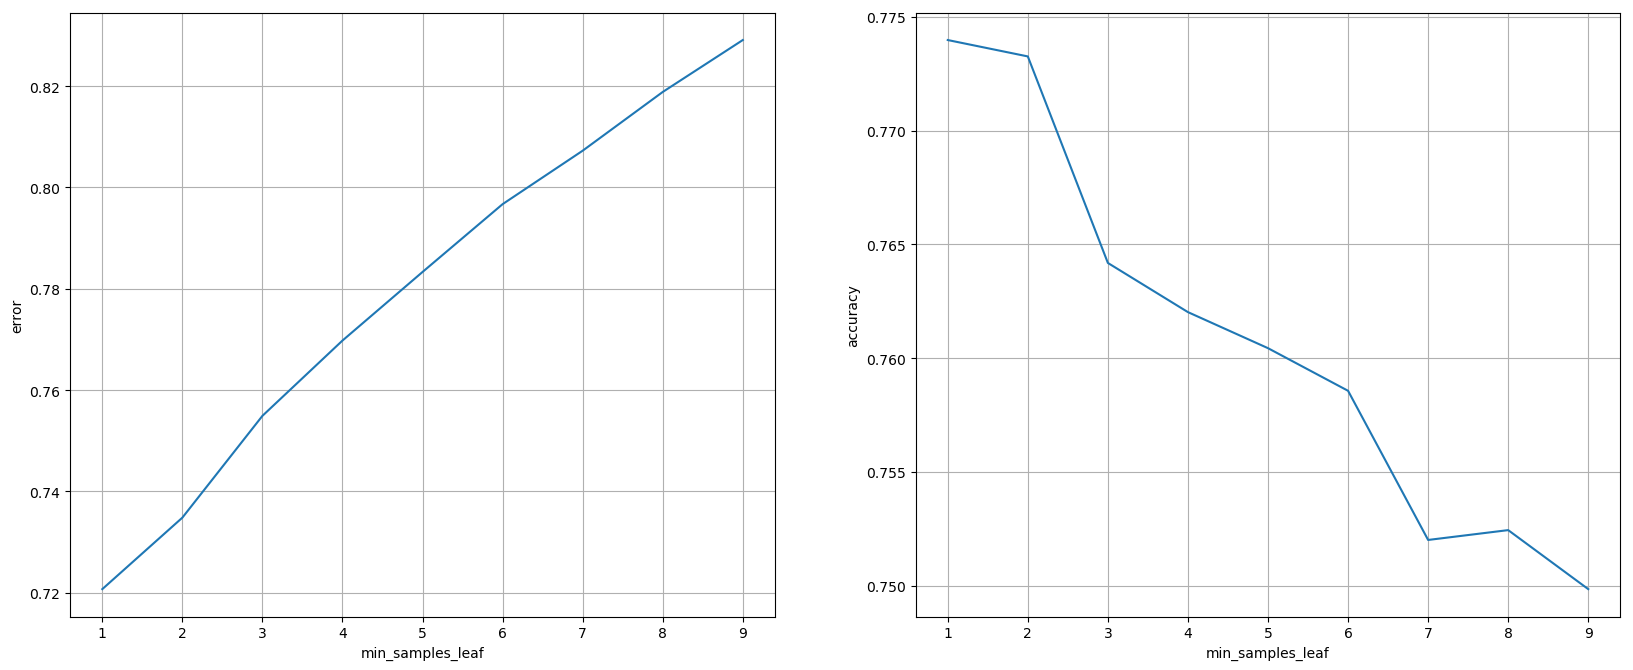

In [53]:
show_para_tune(tuned_parameters, error_t, accuracy_t, 'min_samples_leaf', 'error', 'accuracy')

经过图像展示,最后确定min_sample_leaf=1的时候,表现效果不错

### 确定最优模型
n_estimators=175,

max_depth=30,

max_features=15,

min_samples_leaf=1,

In [55]:
rf3 = RandomForestClassifier(max_depth=30, max_features=15, n_estimators=175,
                       n_jobs=-1, oob_score=True, random_state=40)
rf3.fit(x_train, y_train)

RandomForestClassifier(max_depth=30, max_features=15, n_estimators=175,
                       n_jobs=-1, oob_score=True, random_state=40)

In [56]:
rf3.score(x_test, y_test)

0.7650446300028794

In [57]:
rf3.oob_score_

0.7747695852534562

In [58]:
y_pre_proba1 = rf3.predict_proba(x_test)
log_loss(y_test, y_pre_proba1)

0.7180191391234538

### 生成提交数据

In [59]:
test_data = pd.read_csv('../data/otto/test.csv')
test_data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0


In [60]:
test_data.shape

(144368, 94)

In [61]:
test_data_drop_id = test_data.drop(['id'], axis = 1)
test_data_drop_id.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,0,0,0,0,0,0,0,0,0,3,...,0,0,11,1,20,0,0,0,0,0
1,2,2,14,16,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,0,1,12,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,1,0,0,1,0,0,1,2,0,3,...,0,0,0,0,0,0,0,9,0,0


In [62]:
y_pre_test = rf3.predict_proba(test_data_drop_id)
y_pre_test[:5]

array([[1.71428571e-02, 3.43474903e-02, 9.71428571e-02, 7.37050193e-01,
        5.71428571e-03, 5.74517375e-03, 9.14285714e-02, 1.14285714e-02,
        0.00000000e+00],
       [6.85714286e-02, 9.71428571e-02, 4.28571429e-02, 7.14285714e-02,
        0.00000000e+00, 4.74285714e-01, 1.71428571e-02, 2.00000000e-01,
        2.85714286e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.88571429e-01, 5.71428571e-03, 0.00000000e+00,
        5.71428571e-03],
       [5.14285714e-02, 3.08571429e-01, 2.74285714e-01, 1.82857143e-01,
        0.00000000e+00, 5.71428571e-03, 5.71428571e-03, 1.14285714e-02,
        1.60000000e-01],
       [2.35946916e-01, 5.90964591e-03, 2.41914948e-04, 0.00000000e+00,
        7.91234909e-04, 3.81252734e-04, 3.56087050e-02, 2.92448323e-01,
        4.28672008e-01]])

In [63]:
result_data = pd.DataFrame(y_pre_test, columns=['Class_'+str(i) for i in range(1, 10)])
result_data.head()

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,0.017143,0.034347,0.097143,0.737050,0.005714,0.005745,0.091429,0.011429,0.000000
1,0.068571,0.097143,0.042857,0.071429,0.000000,0.474286,0.017143,0.200000,0.028571
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.988571,0.005714,0.000000,0.005714
3,0.051429,0.308571,0.274286,0.182857,0.000000,0.005714,0.005714,0.011429,0.160000
4,0.235947,0.005910,0.000242,0.000000,0.000791,0.000381,0.035609,0.292448,0.428672


In [64]:
result_data.insert(loc=0, column='id', value = test_data.id)
result_data.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.017143,0.034347,0.097143,0.737050,0.005714,0.005745,0.091429,0.011429,0.000000
1,2,0.068571,0.097143,0.042857,0.071429,0.000000,0.474286,0.017143,0.200000,0.028571
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.988571,0.005714,0.000000,0.005714
3,4,0.051429,0.308571,0.274286,0.182857,0.000000,0.005714,0.005714,0.011429,0.160000
4,5,0.235947,0.005910,0.000242,0.000000,0.000791,0.000381,0.035609,0.292448,0.428672


In [65]:
result_data.to_csv('../data/otto/submission.csv', index=False)